# Setup

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation, plot_distribution, expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.experimental.train_AIS import AIS_trainer
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG

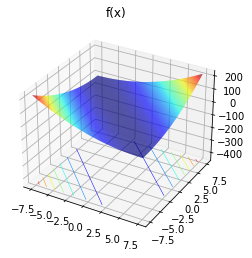

In [3]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Let's go

## Setup Problem

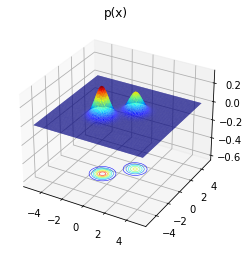

In [4]:
torch.manual_seed(6)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = custom_MoG(dim=dim, cov_scaling=0.3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
fig = plot_distribution(target, bounds=[[-5, 5], [-5, 5]])

In [5]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", k=10)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

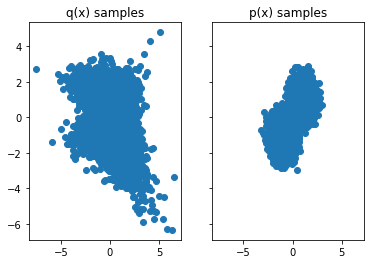

In [6]:
samples_before = plot_samples(tester, n_samples=int(1e4))

In [103]:
def run(k, tester=tester):
    tester.k = k
    grads = tester.get_gradients(n_batches=1000, batch_size=k)
    stds = torch.std(grads, dim=0)
    means = torch.mean(grads, dim=0)
    SNR = torch.abs(means/stds)
    return SNR, means, stds

In [104]:
from tqdm.notebook import tqdm

In [105]:
k_options = [1, 2, 5, 10, 50, 100, 1000]
history = {"SNR":[],
          "means":[],
          "stds":[]}
for k in tqdm(k_options):
    SNR, means, stds = run(k)
    history["SNR"].append(SNR)
    history["means"].append(means)
    history["stds"].append(stds)
history["SNR"] = torch.stack(history["SNR"])
history["means"] = torch.stack(history["means"])
history["stds"] = torch.stack(history["stds"])

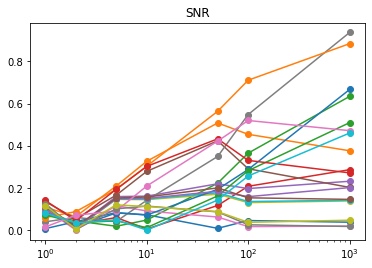

In [106]:
plt.plot(k_options, history["SNR"][:, :, 1], "o-")
plt.title("SNR")
plt.xscale("log")
plt.show()

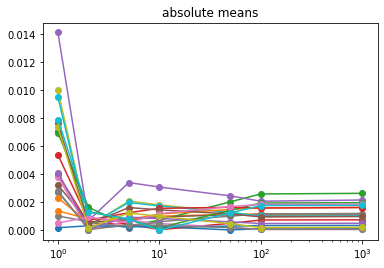

In [107]:
plt.plot(k_options, torch.abs(history["means"][:, :, 1]), "o-")
plt.xscale("log")
plt.title("absolute means")
plt.show()

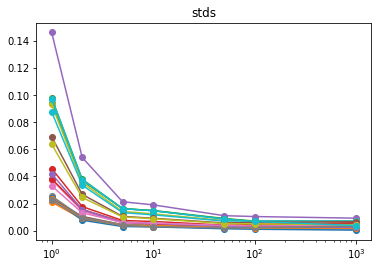

In [108]:
plt.plot(k_options, history["stds"][:, :, 1], "o-")
plt.title("stds")
plt.xscale("log")
plt.show()

## After some training

In [110]:
tester.k = 100

In [111]:
history = tester.train(100, batch_size=int(1e2))

loss: -0.16655318439006805, mean log p_x -2.6107077598571777: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.49it/s]


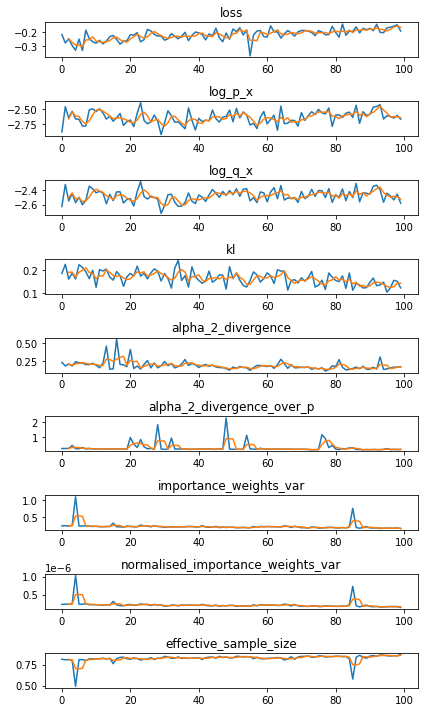

In [112]:
fig = plot_history(history)

In [113]:
k_options = [1, 2, 10, 50, 100]
history = {"SNR":[],
          "means":[],
          "stds":[]}
for k in tqdm(k_options):
    SNR, means, stds = run(k)
    history["SNR"].append(SNR)
    history["means"].append(means)
    history["stds"].append(stds)
history["SNR"] = torch.stack(history["SNR"])
history["means"] = torch.stack(history["means"])
history["stds"] = torch.stack(history["stds"])

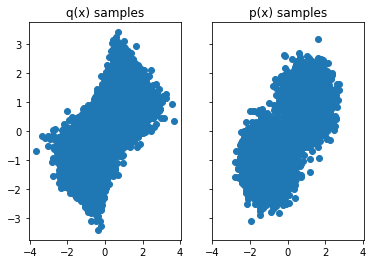

In [118]:
samples_after = plot_samples(tester, n_samples=int(1e4))

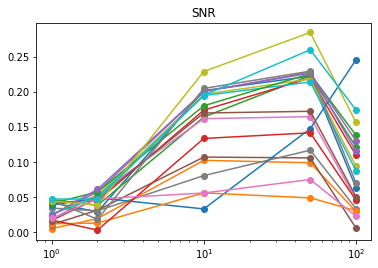

In [114]:
plt.plot(k_options, history["SNR"][:, :, 1], "o-")
plt.xscale("log")
plt.title("SNR")
plt.show()

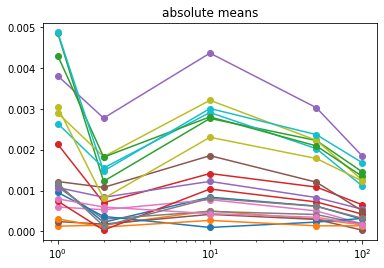

In [117]:
plt.plot(k_options, torch.abs(history["means"][:, :, 1]), "o-")
plt.xscale("log")
plt.title("absolute means")
plt.show()

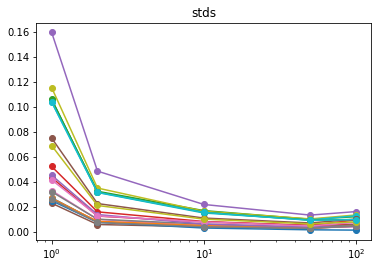

In [116]:
plt.plot(k_options, history["stds"][:, :, 1], "o-")
plt.xscale("log")
plt.title("stds")
plt.show()